# Monte Carlo simulation of Dynamic Risk Budgeting between PSP and GHP

We've looked at the fundamental problem of how much to allocate in the safe asset vs the performance seeking asset, and we investigated static and glidepath based techniques. Now we'll look at modern dynamic techniques that are inspired by CPPI to ensure that the account value reaches a certain target minimum floor, but also maintains exposure to the upside through a dynamic risk budget

Let's start by building 500 scenarios for interest rates, an duration matched bond portfolio (proxied by a zero coupon bond) and a stock portfolio.

In [144]:
n_scenarios =  5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=0.03, r_0 = 0.03, sigma=0.02)
price_eq = erk.gbm(n_years=10,n_scenarios=n_scenarios, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=0.7)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75)],
          axis=1).round(2)

,ZC,Eq,70/30
mean,1.35,1.98,1.76
std,0.00,0.99,0.60
p_breach,NaN,0.03,0.01
e_breach,NaN,0.13,0.06
p_reach,NaN,NaN,NaN
e_reach,NaN,NaN,NaN


Let's write a new allocator that we'll call a Floor Allocator applies a dynamic risk budget to allocate more to the PSP when there is a cushion, similar to what we did for CPPI


In [147]:

def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC Prices must have the same shape")
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] ## PV of Floor assuming today's rates and flat YC
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history


In [148]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, floor=.75,  zc_prices=zc_prices[1:])
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75
mean,1.35,1.98,1.76,1.95
std,0.00,0.99,0.60,1.00
p_breach,NaN,0.03,0.01,NaN
e_breach,NaN,0.13,0.06,NaN
p_reach,NaN,NaN,NaN,NaN
e_reach,NaN,NaN,NaN,NaN


In [150]:
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=5)
rets_floor75m10 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, zc_prices=zc_prices[1:], floor=.75, m=10)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75)
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m5,Floor75m10
mean,1.35,1.98,1.76,1.95,1.96,1.97
std,0.00,0.99,0.60,1.00,1.00,1.00
p_breach,NaN,0.03,0.01,NaN,NaN,0.01
e_breach,NaN,0.13,0.06,NaN,NaN,0.01
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_reach,NaN,NaN,NaN,NaN,NaN,NaN


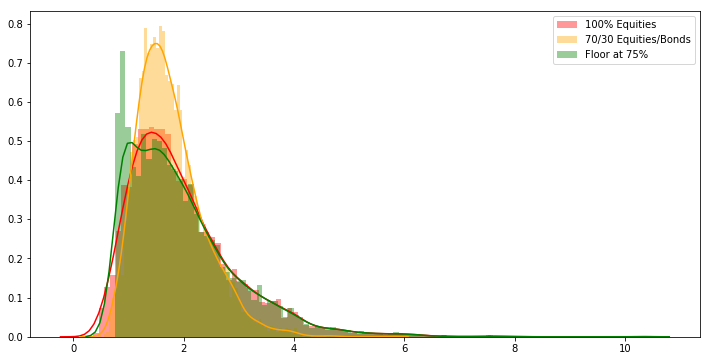

In [151]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)

plt.legend();

## Dynamic Risk Budgeting with Drawdown instead of a fixed floor

In [152]:
def drawdown_allocator(psp_r, ghp_r, maxdd, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple
    of the cushion in the PSP
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    ### For MaxDD
    peak_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        ### For MaxDD
        floor_value = (1-maxdd)*peak_value ### Floor is based on Prev Peak
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0, 1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        ### For MaxDD
        peak_value = np.maximum(peak_value, account_value) ### For MaxDD
        w_history.iloc[step] = psp_w
    return w_history

In [153]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75),
           erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)           
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m5,Floor75m10,MaxDD25
mean,1.35,1.98,1.76,1.95,1.96,1.97,1.63
std,0.00,0.99,0.60,1.00,1.00,1.00,0.55
p_breach,NaN,0.03,0.01,NaN,NaN,0.01,NaN
e_breach,NaN,0.13,0.06,NaN,NaN,0.01,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN


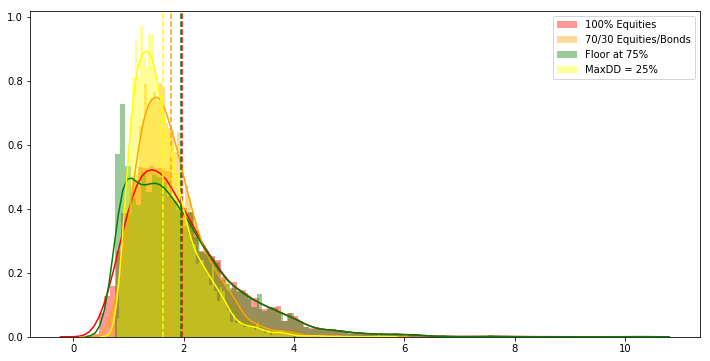

In [154]:
# Plot
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
#plt.axvline(tv_zc.mean(), ls="--", color="blue")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend();

## Backtesting Dynamic Strategies with Historical Data

Try and work with real historic data such as a the Industry Portfolios or the Total Market Index we constructed and run back tests with different parameter values. For instance:

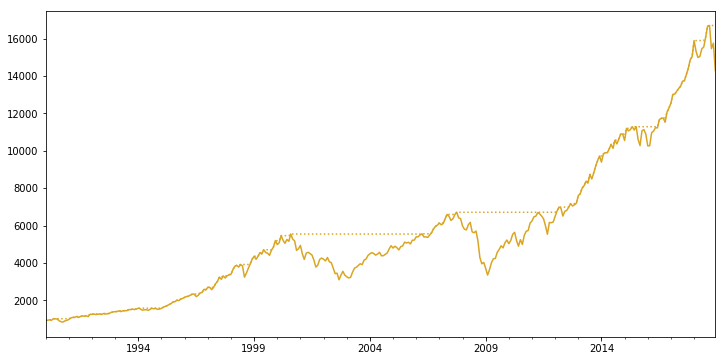

In [156]:
rets_tmi =  erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod");

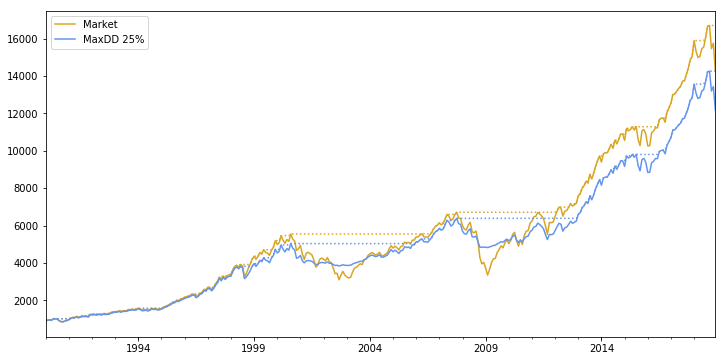

In [159]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Peaks"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Peaks"].plot(ax=ax, color="cornflowerblue", ls=":");